In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Download the codeSearchNetChallenge dataset 
_If needed_

In [2]:
%run downloading_cleaning_codeSearchNetChallenge_dataset.ipynb

CodeSearchNet challenge dataset ready to use!


## Exporting the codeSearchNetChallenge dataset to CSV files

_If needed_

In [3]:
%run preparing_csv_files_from_codeSearchNetChallenge_dataset.ipynb

Total lines of Python code in the dataset (after removing empty lines)
11206193


Total lines of Python code in the dataset's train folder (after removing empty lines)
10054266


Total lines of Python in the dataset's test folder (after removing empty lines)
541338


Total lines of Python in the dataset's valid folder
610589


## Training tokenizer using SentencePiece

_model_type=word_

In [4]:
import torch
print ('Current cuda device in use: ', torch.cuda.current_device())

Current cuda device in use:  0


In [5]:
from fastai.text import *
import sentencepiece as spm #https://github.com/google/sentencepiece

In [6]:
# TODO: Experiment with more vocab size like 800, 1000 or 1200
vocab_size = 600
model_prefix = 'word_model'

In [7]:
codeSearchNet_challenge_path = './CodeSearchNet_challenge_dataset'
all_csv_path = './CodeSearchNet_challenge_dataset/CodeSearchNet_challenge_dataset.csv'
train_csv_path = './CodeSearchNet_challenge_dataset/python/final/jsonl/train/train_CodeSearchNet_challenge_dataset.csv'
test_csv_path = './CodeSearchNet_challenge_dataset/python/final/jsonl/test/test_CodeSearchNet_challenge_dataset.csv'
valid_csv_path = './CodeSearchNet_challenge_dataset/python/final/jsonl/valid/valid_CodeSearchNet_challenge_dataset.csv'

In [8]:
spm.SentencePieceTrainer.Train(f'--input={all_csv_path}'\
                               f' --model_prefix={model_prefix}'\
                               f' --vocab_size={vocab_size}'\
                               f' --model_type=word'\
                               f' --unk_piece={UNK} --bos_piece={BOS} --eos_id=-1 --pad_piece={PAD}')

In [9]:
## load up the Processor
sp = spm.SentencePieceProcessor()
sp.load(f'{model_prefix}.model')

True

In [10]:
itos = []
with open(f'{model_prefix}.vocab','r') as f:
    for line_num,line in enumerate(f):
        itos.append(line.split("\t")[0])

class SPTokenizer(BaseTokenizer):
    "Wrapper around a SentncePiece tokenizer to make it a `BaseTokenizer`."
    def __init__(self, model_prefix:str):
        self.tok = spm.SentencePieceProcessor()
        self.tok.load(f'{model_prefix}.model')

    def tokenizer(self, t:str) -> List[str]:
        return self.tok.EncodeAsPieces(t)
    
class CustomTokenizer():
    '''Wrapper for SentencePiece toeknizer to fit into Fast.ai V1'''
    def __init__(self,tok_func:Callable,model_prefix:str, pre_rules:ListRules=None):
        self.tok_func,self.model_prefix = tok_func,model_prefix
        self.pre_rules  = ifnone(pre_rules,  defaults.text_pre_rules )
        
    def __repr__(self) -> str:
        res = f'Tokenizer {self.tok_func.__name__} using `{self.model_prefix}` model with the following rules:\n'
        for rule in self.pre_rules: res += f' - {rule.__name__}\n'
        return res        

    def process_text(self, t:str,tok:BaseTokenizer) -> List[str]:
        "Processe one text `t` with tokenizer `tok`."
        for rule in self.pre_rules: t = rule(t)  
        toks = tok.tokenizer(t)
        #post rules?
        return toks 
    
    def _process_all_1(self,texts:Collection[str]) -> List[List[str]]:
        'Process a list of `texts` in one process'
        tok = self.tok_func(self.model_prefix)
        return [self.process_text(t,tok) for t in texts]
                                                                     
    def process_all(self, texts:Collection[str]) -> List[List[str]]: 
        "Process a list of `texts`."                                 
        return self._process_all_1(texts)


In [11]:
mycust_tok = CustomTokenizer(SPTokenizer, model_prefix)

In [12]:
#setup Vocab object for use in LM
sp_vocab = Vocab(itos)

In [13]:
data = TextLMDataBunch.from_csv('./', train_csv_path, test=test_csv_path, tokenizer=mycust_tok, vocab=sp_vocab)

In [14]:
data.show_batch()

/opt/tljh/user/lib/python3.7/site-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


idx,text
0,▁list ▁or ▁str ▁:param xxunk ▁The xxunk ▁column ▁names ▁that ▁are ▁required ▁as ▁the ▁first ▁line ▁of ▁the ▁mapping ▁file ▁:rtype: ▁None xxunk ▁if xxunk ▁header ▁= xxunk ▁\ xxunk ▁+ xxunk ▁with xxunk ▁as xxunk ▁for ▁row ▁in xxunk ▁\ xxunk ▁+ xxunk ▁def xxunk ▁a ▁file ▁each xxunk ▁a ▁full xxunk ▁This ▁method xxunk ▁that ▁file ▁into ▁a xxunk ▁with xxunk ▁= xxunk ▁:type xxunk ▁file ▁or ▁str
1,"▁variable ▁/ xxunk ▁/ xxunk ▁/ ▁output ▁/ xxunk ▁/ xxunk ▁If ▁this ▁variable ▁is xxunk ▁in ▁the ▁source xxunk ▁file, ▁then xxunk ▁is xxunk ▁as ▁a xxunk ▁method. xxunk ▁to xxunk ▁this ▁variable ▁should ▁do ▁so ▁via xxunk ▁state xxunk ▁if xxunk ▁v ▁= xxunk ▁try: ▁t ▁= xxunk ▁except xxunk ▁raise xxunk ▁must ▁be ▁of ▁a ▁type xxunk ▁with xxunk ▁}) xxunk ▁= ▁t ▁if xxunk ▁def xxunk"
2,"xxunk ▁+= xxunk ▁return xxunk ▁# xxunk ▁case ▁is ▁a ▁single ▁string ▁without ▁any xxunk ▁if xxunk ▁not ▁in xxunk ▁return xxunk ▁# ▁The xxunk ▁case ▁is ▁a ▁string ▁with ▁some xxunk ▁in ▁it ▁i ▁= xxunk ▁= xxunk ▁+ xxunk ▁= xxunk ▁= xxunk ▁return xxunk ▁for ▁word ▁in xxunk ▁def xxunk ▁Create ▁a ▁header ▁a ▁new ▁image xxunk ▁= xxunk ▁== xxunk ▁values ▁= ▁[ xxunk ▁2, xxunk"
3,xxunk ▁a ▁filter ▁URL ▁to ▁an xxunk ▁of ▁all ▁objects ▁with xxunk ▁field xxunk ▁url ▁= xxunk ▁+ xxunk ▁= xxunk ▁query ▁= xxunk ▁= xxunk ▁return xxunk ▁def xxunk ▁a ▁function ▁that xxunk ▁to ▁a xxunk ▁of ▁all ▁objects ▁with xxunk ▁field xxunk ▁fields ▁= xxunk ▁+ ▁fields xxunk ▁= xxunk ▁/ xxunk ▁def xxunk ▁value ▁= xxunk ▁None) xxunk ▁= ▁name ▁or ▁value xxunk ▁= xxunk ▁for xxunk
4,"xxunk ▁return xxunk ▁def xxunk ▁convert xxunk ▁as ▁returned ▁by xxunk ▁to xxunk ▁# ▁index ▁where ▁there ▁are xxunk ▁and ▁they xxunk ▁d ▁= xxunk ▁and xxunk ▁> ▁0) ▁return xxunk ▁v ▁for ▁k, ▁v ▁in xxunk ▁def xxunk ▁a ▁column ▁containing xxunk ▁d ▁= xxunk ▁if xxunk ▁> ▁0: ▁if ▁values ▁is ▁None: ▁values ▁= xxunk ▁for ▁value ▁in xxunk ▁name ▁= xxunk ▁if xxunk ▁is ▁dict ▁else xxunk"


In [15]:
data.save('20200811_word_model_databunch_data_save.pkl') 

In [18]:
data = load_data('./', '20200811_word_model_databunch_data_save.pkl', bs=1600)

In [19]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.3)

In [20]:
print(learn.model)

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(600, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(600, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=600, bias=True)
    (output_dp): RNNDropout()
  )
)


In [21]:
learn.summary()

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [70, 400]            0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
Linear               [70, 600]            240,600    True      
______________________________________________________________________
RNNDropout           [70, 400]            0          False     
______________________________________________________________________

Total params: 240,600
Total trainable params: 240,600
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function

In [22]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-02
Min loss divided by 10: 2.75E-01


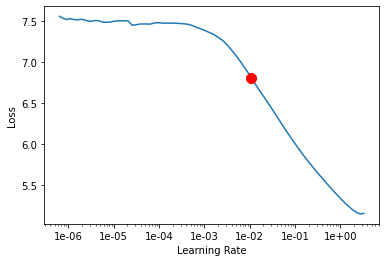

In [23]:
learn.recorder.plot(suggestion=True)

In [24]:
learn.fit_one_cycle(1, slice(1e-1, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,2.939120,2.809371,0.449117,03:50


In [25]:
learn.save('20200811_fit_head_word_model_drop_mult')

In [26]:
learn.load('20200811_fit_head_word_model_drop_mult');

In [27]:
learn.unfreeze()

In [28]:
learn.fit_one_cycle(30, slice(1e-1, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,3.175289,2.986178,0.436709,05:37
1,2.810483,2.717596,0.459933,05:37
2,2.627679,2.650343,0.462896,05:37
3,2.480752,2.473624,0.482531,05:38
4,2.452791,2.481973,0.480046,05:38
5,2.455511,2.479025,0.477426,05:38
6,2.579818,2.557277,0.470739,05:35
7,2.542310,2.522521,0.475464,05:35
8,2.521100,2.503774,0.476018,05:35
9,2.478536,2.685338,0.454895,05:36


In [29]:
# learn.save('fine_tuned')
learn.save('20200811_fine_tuned_word_model_drop_mult')

In [30]:
# learn.load('fine_tuned');
learn.load('20200811_fine_tuned_word_model_drop_mult');

In [31]:
TEXT = "import from"
N_WORDS = 25
N_SENTENCES = 3
for _ in range(N_SENTENCES):
    predicted = learn.predict(TEXT, N_WORDS, temperature=0.9)
    val = predicted.replace(TEXT, '')
    decoded = sp.decode_pieces(val.split())
    print(TEXT + " "+  decoded)

import from multiple class if it is in a set of global different data up for the specified model node in the list of attribute names in
import from the API to a different instance of the current existing of the update as a dict of this from the new class information to the
import from a command - a specific task like \ \ * \ \ * \ \ \ \ 3 \ \ \ \ \ \ \


In [32]:
print(learn.summary()) 

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [70, 400]            0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
Linear               [70, 600]            240,600    True      
______________________________________________________________________
RNNDropout           [70, 400]            0          False     
______________________________________________________________________

Total params: 240,600
Total trainable params: 240,600
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function